# Saturation mutagenesis plots, Kircher data

In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

import dmslogo
import palettable
import dmslogo.colorschemes
from dmslogo.colorschemes import CBPALETTE

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Functions not yet added to the repo

In [2]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis  
        self.dual_pred = dual_pred
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

## Load the model

In [3]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



archive unpacked in ./


## Load Kircher's data

In [4]:
all_satmut_df = pd.read_csv('gs://syrgoth/data/saturation_mutagenesis/GRCh38_ALL.csv') #GRCh38_LDLR.csv
all_satmut_df = all_satmut_df[all_satmut_df.Alt != '-'].reset_index(drop=True)

element_cells = {'F9': 1, 'LDLR': 1, 'LDLR.2': 1, 'PKLR-24h': 0, 'PKLR-48h': 0, 'SORT1': 1, 'SORT1.2': 1}
                 #'HNF4A':1, 'MYCrs6983267':1}

## Get in-vitro variant effects and compute in-silico variant effects

In [23]:
element = 'SORT1'
    
satmut_df = all_satmut_df[all_satmut_df.Element == element].reset_index(drop=True)

#in-vitro
coords = sorted(set(satmut_df.Position))

region_sequence = ''
region_values = []
for coord in coords:
    temp_df = satmut_df[satmut_df.Position == coord]
    site_ref = next(iter(set(temp_df.Ref)))
    region_sequence += site_ref
    site_alts = sorted(temp_df.Alt)
    site_values = torch.zeros(4)
    for site in site_alts:
        site_values[constants.STANDARD_NT.index(site)] = float(temp_df[temp_df.Alt == site].Value)
    region_values.append(site_values)
in_vitro_satmut = torch.stack(region_values, dim=1).numpy()

#in-silico
step_size = 1
window_size = 200
cell_type = element_cells[element]
#predictor = mpra_predictor(model=model, pred_idx=cell_type).cuda()
predictor = mpra_predictor(model=model, pred_idx=cell_type, dual_pred=True).cuda()

windows_as_strings = [region_sequence[i:i+window_size] for i in range(0, len(region_sequence)-window_size, step_size)]
predicted_saturations = []
for sequence_as_string in tqdm(windows_as_strings):
    combinations = []
    for idx in range(len(sequence_as_string)):
        four_combinations = torch.stack([utils.dna2tensor(sequence_as_string[:idx] + base + sequence_as_string[idx+1:]) for base in constants.STANDARD_NT])
        combinations.append(four_combinations)
    combinations = torch.stack(combinations).flatten(0,1)   
    base_prediction = predictor(utils.dna2tensor(sequence_as_string).view(1,4,-1).cuda()).detach().cpu()
    sat_preds = predictor(combinations.cuda()).detach().cpu()   
    predicted_saturations.append(sat_preds.unflatten(0, (200, 4)).T - base_prediction) 
predicted_saturations = torch.stack(predicted_saturations)

num_channels = predicted_saturations.shape[1]
num_windows = predicted_saturations.shape[0]
window_size = predicted_saturations.shape[-1]
if step_size != 1:
    last_window_start =  step_size * (num_windows - 1)
else:
    last_window_start =  step_size * num_windows

locus_length = last_window_start + window_size
full_window_contributions = torch.zeros(num_channels, locus_length)
for i in range(0, last_window_start, step_size):
    full_window_contributions[:,i:i+window_size] += predicted_saturations[i//step_size,:,:].detach().cpu()

max_num_windows = min(200, locus_length - window_size)
if locus_length > 2*window_size:
    divisors = torch.tensor(list(range(1, max_num_windows+1)) + (locus_length - 2*window_size)*[max_num_windows] + list(reversed(range(1, max_num_windows+1))))
else:
    divisors = torch.tensor(list(range(1, max_num_windows+1)) + (window_size - max_num_windows)*[max_num_windows] + list(reversed(range(1, max_num_windows+1))))
saturated_contributions = full_window_contributions.div(divisors)
locus_tensor = utils.dna2tensor(region_sequence)
in_silico_satmut = (saturated_contributions * (torch.ones_like(locus_tensor) - locus_tensor)).numpy()


  0%|          | 0/400 [00:00<?, ?it/s]

## Variant effect predictions scatter plot

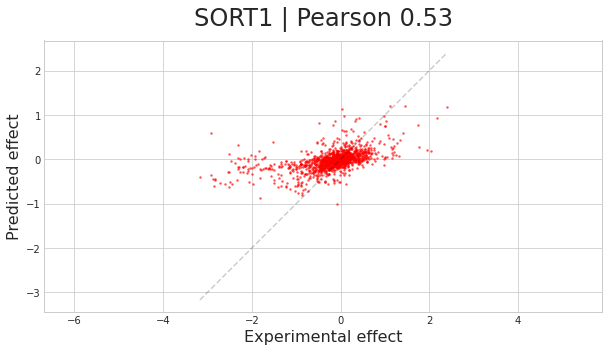

In [25]:
title_element_name = element #'PKLR-48h'

#scatter
in_vitro_flat = in_vitro_satmut[np.nonzero(in_vitro_satmut)].flatten()
in_silico_flat = in_silico_satmut[np.nonzero(in_vitro_satmut)].flatten()
pearson = round(np.corrcoef(in_vitro_flat, in_silico_flat)[0,1], 2)
spearman = round(stats.spearmanr(in_vitro_flat, in_silico_flat)[0], 2)

color_list = ['blue', 'red', 'green']
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10,5))
    cm = plt.cm.get_cmap('copper')    
    #plt.scatter(in_vitro_flat, in_silico_flat, alpha=0.5, cmap=cm, marker='.', color='C'+str(cell_type))
    plt.scatter(in_vitro_flat, in_silico_flat, alpha=0.5, cmap=cm, marker='.', color=color_list[cell_type], s=10.0)

    x_min, y_min = in_vitro_flat.min(), in_silico_flat.min()
    x_max, y_max = in_vitro_flat.max(), in_silico_flat.max()
    min_point, max_point = min(x_min, y_min), max(x_max, y_max)
    plt.plot((min_point, max_point), (min_point, max_point), color='black', linestyle='--', alpha=0.2)
#         plt.axhline(0, color='black', alpha=0.2, linestyle='-')
#         plt.axvline(0, color='black', alpha=0.2, linestyle='-')
    plt.axis('equal')
    #plt.title(f'{element} - {cell_names[cell_type]} | Pearson {pearson}  Spearman: {spearman}')
    #plt.title(f'{element} | Pearson={pearson}  Spearman={spearman}', fontsize=24, pad=15, fontweight='medium')
    plt.title(f'{title_element_name} | Pearson {pearson}', fontsize=24, pad=15, fontweight='medium')
    plt.xlabel('Experimental effect', fontsize=16)
    plt.ylabel('Predicted effect', fontsize=16)
#     fig_path = 'figures/' + f'{element}_scatter' + '.png'
#     plt.savefig(fig_path, transparent=True )
    fig_path = 'figures/' + f'{element}_scatter' + '.pdf'
    plt.savefig(fig_path)
    plt.show()

## Variant effect stem plots

In [26]:
# get y limits
y_max = max(in_vitro_satmut.max(), in_silico_satmut.max()) + 0.2
y_min = min(in_vitro_satmut.min(), in_silico_satmut.min()) - 0.2

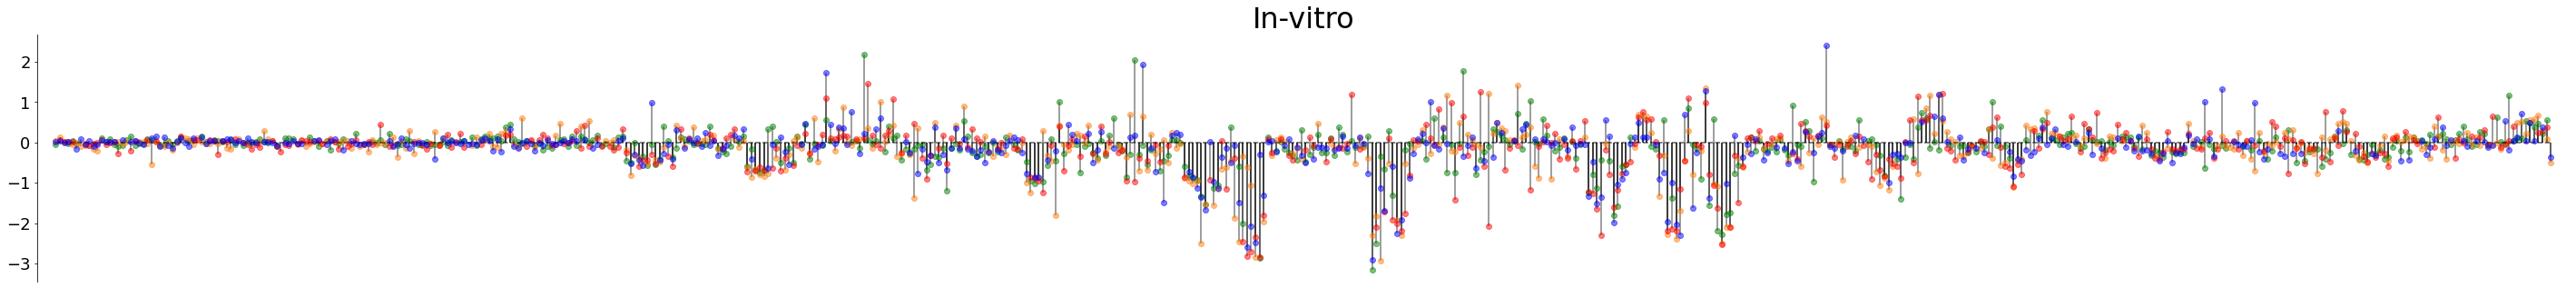

In [27]:
# settings
effect_array = in_vitro_satmut
colors       = ['g', 'C1', 'r', 'b']
figsize      = (50,5)
stem_offset  = 0.0
marker_alpha = 0.5
stem_alpha   = 0.5
linestyle    = 'solid'

#plot
markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=figsize)

offset = 0
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = plt.stem(locs + offset, heads, 'k', markerfmt=markerfmts[i])
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    offset += stem_offset
    
plt.margins(x=0.0075)
#plt.ylim(y_min, y_max)
#plt.axis('off')
plt.xticks([])
#plt.box(False)
plt.yticks(fontsize=18)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('In-vitro', fontsize=32) 

fig_path = 'figures/' + f'{element}_invitro' + '.pdf'
plt.savefig(fig_path)
    
plt.show()

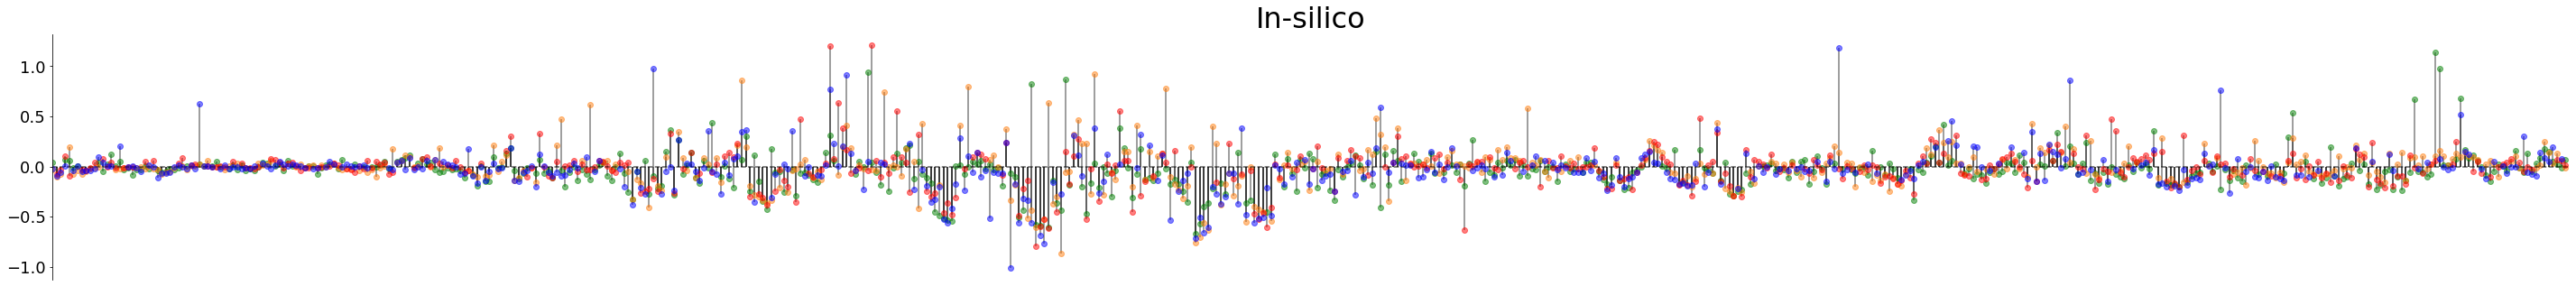

In [28]:
# settings
effect_array = in_silico_satmut
colors       = ['g', 'C1', 'r', 'b']
figsize      = (50,5)
stem_offset  = 0.0
marker_alpha = 0.5
stem_alpha   = 0.5
linestyle    = 'solid'

#plot
markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=figsize)

offset = 0
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = plt.stem(locs + offset, heads, 'k', markerfmt=markerfmts[i])
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    offset += stem_offset
    
#plt.margins(x=0.0075)
plt.margins(x=0.0)
#plt.ylim(y_min, y_max)
#plt.axis('off')
plt.xticks([])
#plt.box(False)
plt.yticks(fontsize=18)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('In-silico', fontsize=32) 

fig_path = 'figures/' + f'{element}_insilico' + '.pdf'
plt.savefig(fig_path)

plt.show()

## Mean variant effect size logos

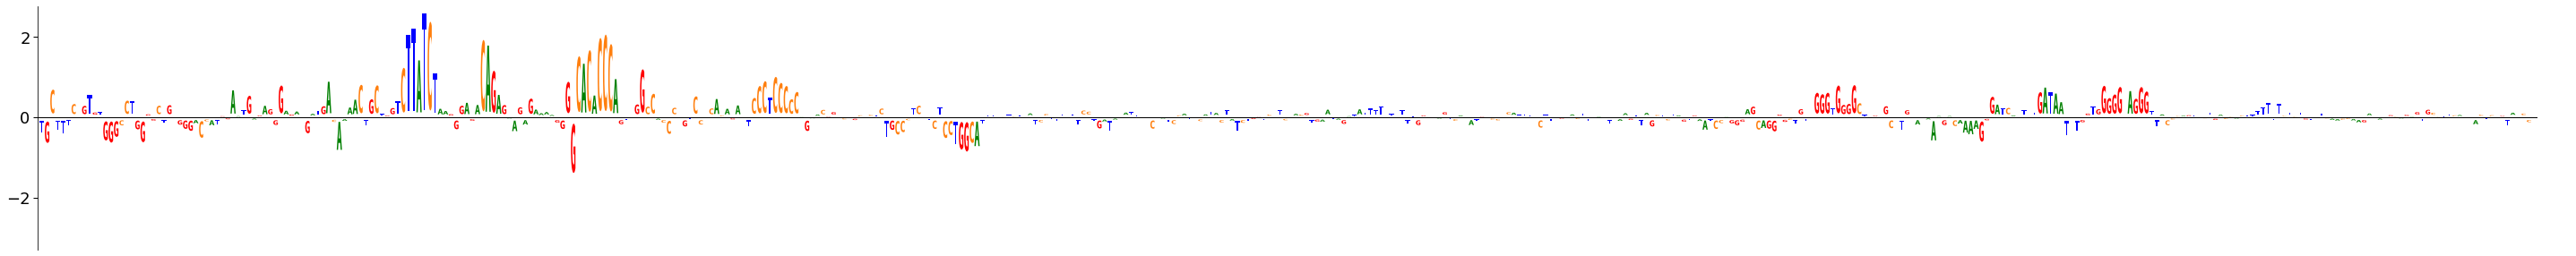

In [14]:
# settings
ref_sequence_str = region_sequence
contributions_array = in_vitro_satmut
figsize=(50,5)

#plot
ref_array = utils.dna2tensor(ref_sequence_str).numpy()
effect_array = (np.ones_like(ref_array) - ref_array) * contributions_array

fig, ax = plt.subplots(figsize=(50,5))
plt.margins(x=0.0075)

effect_means = - effect_array.sum(axis=0) / 3.0

temp_data = [list(ref_sequence_str), effect_means]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height']

temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
temp_df['site'] = temp_df.index

y_max = max(effect_array.max(), effect_means.max()) + 0.1
y_min = min(effect_array.min(), effect_means.min()) - 0.1

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

plt.margins(x=0.0075)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.spines['bottom'].set_visible(False)

#plt.box(False)
plt.ylabel('')
plt.yticks(fontsize=18)

fig_path = 'figures/' + f'{element}_meaneffects' + '.pdf'
plt.savefig(fig_path, format='pdf')

plt.show()

## Stems + Logo

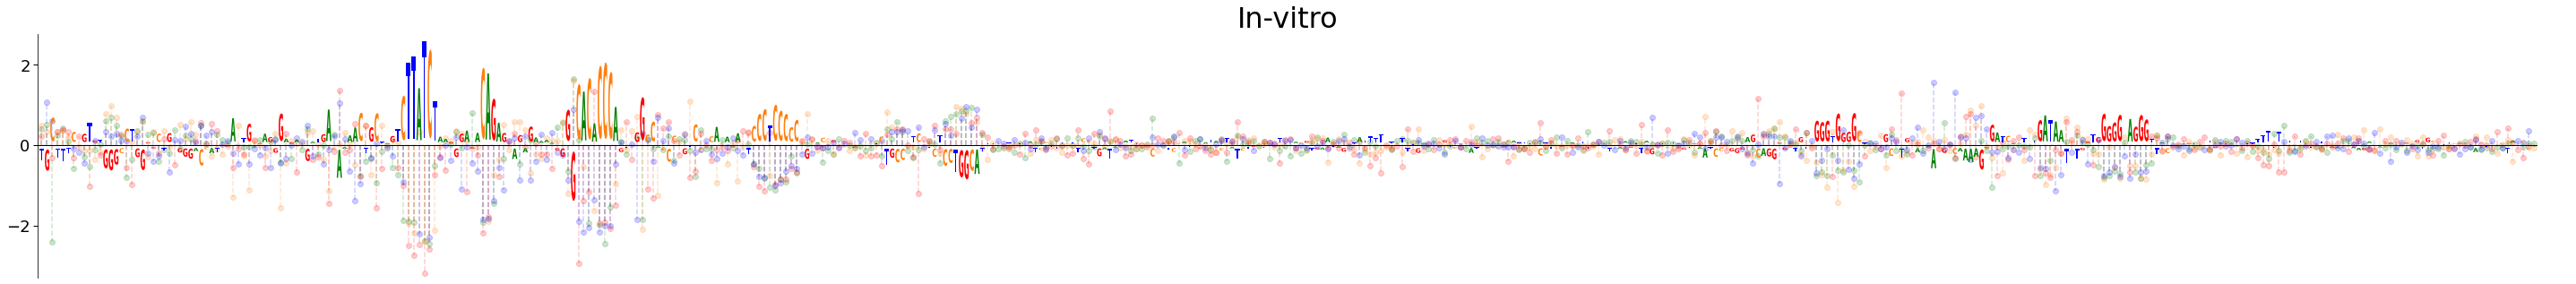

In [15]:
ref_sequence_str = region_sequence
effect_array     = in_vitro_satmut
lfcSE_array      = None
ref_lfcSE        = None
colors           = ['g', 'C1', 'r', 'b']
figsize          = (50,5),
marker_alpha     = 0.2
stem_alpha       = 0.2
linestyle        = 'dashed'


markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=(50,5))

offset = 0.5
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    #plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    #offset += 0.1
    
plt.margins(x=0.0075)

effect_means = - effect_array.sum(axis=0) / 3.0

if lfcSE_array is not None and ref_lfcSE is not None:
    lfcSE_means = lfcSE_array.sum(axis=0) / 3.0  
    alphas = np.minimum(np.maximum(lfcSE_means, ref_lfcSE), 0.90)
    shade_color_col='color'
    shade_alpha_col='shade'
else:
    alphas = np.empty(effect_means.shape[0])
    alphas[:] = np.nan
    shade_color_col=None
    shade_alpha_col=None

temp_data = [list(ref_sequence_str), effect_means, alphas]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height', 'shade']

temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
temp_df['site'] = temp_df.index

y_max = max(effect_array.max(), effect_means.max()) + 0.1
y_min = min(effect_array.min(), effect_means.min()) - 0.1

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        shade_color_col=shade_color_col,
                        shade_alpha_col=shade_alpha_col,
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

#plt.title('In-vitro', fontsize=32) 

plt.xticks([])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.spines['bottom'].set_visible(False)

plt.ylabel('')
plt.yticks(fontsize=18)
plt.title('In-vitro', fontsize=32) 

fig_path = 'figures/' + f'{element}_invitro_combined' + '.pdf'
plt.savefig(fig_path, format='pdf')

plt.show()

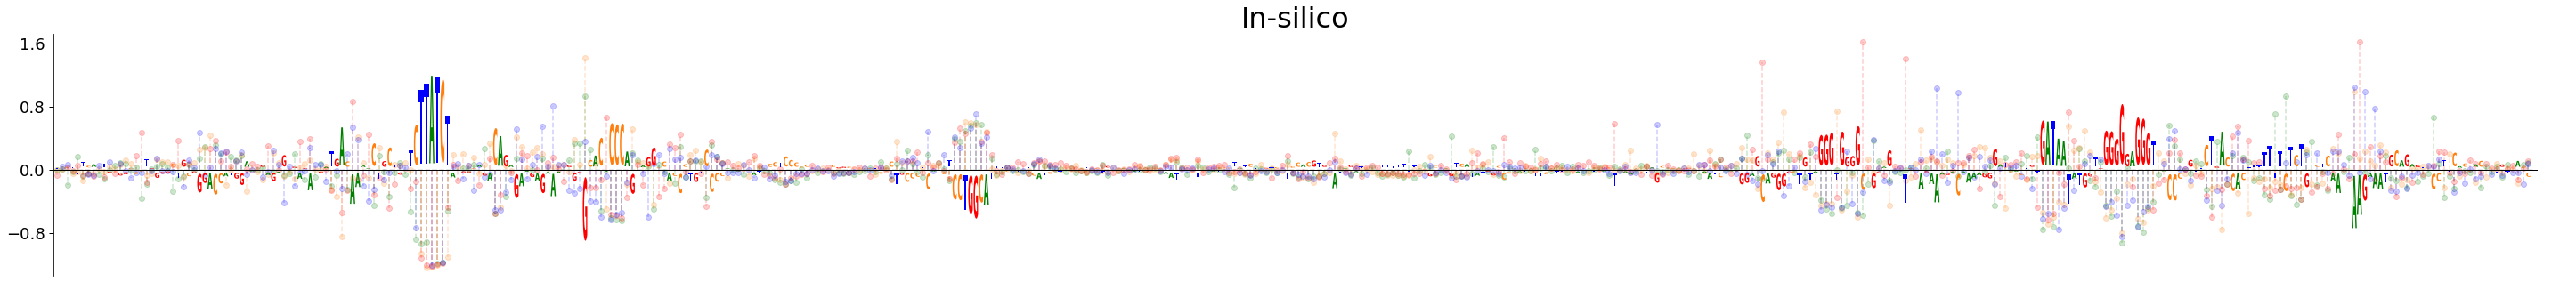

In [16]:
ref_sequence_str = region_sequence
effect_array     = in_silico_satmut
lfcSE_array      = None
ref_lfcSE        = None
colors           = ['g', 'C1', 'r', 'b']
figsize          = (50,5),
marker_alpha     = 0.2
stem_alpha       = 0.2
linestyle        = 'dashed'


markerfmts = [color + 'o' for color in colors]
locs = np.arange(0, effect_array.shape[1])
fig, ax = plt.subplots(figsize=(50,5))

offset = 0.5
for i in range(4):
    heads = np.array(effect_array[i,:], copy=True)
    heads[heads == 0.] = np.nan
    markerline, stemlines, baseline = ax.stem(locs + offset, heads, colors[i], markerfmt=markerfmts[i], basefmt='0.8')
    plt.setp(stemlines, 'linestyle', linestyle)
    plt.setp(stemlines, 'alpha', stem_alpha)
    plt.setp(markerline, 'alpha', marker_alpha)
    #plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'alpha', 0.2)
    plt.setp(baseline, 'linestyle', 'dashed')

    #offset += 0.1
    
plt.margins(x=0.0075)

effect_means = - effect_array.sum(axis=0) / 3.0

if lfcSE_array is not None and ref_lfcSE is not None:
    lfcSE_means = lfcSE_array.sum(axis=0) / 3.0  
    alphas = np.minimum(np.maximum(lfcSE_means, ref_lfcSE), 0.90)
    shade_color_col='color'
    shade_alpha_col='shade'
else:
    alphas = np.empty(effect_means.shape[0])
    alphas[:] = np.nan
    shade_color_col=None
    shade_alpha_col=None

temp_data = [list(ref_sequence_str), effect_means, alphas]
temp_df = pd.DataFrame(temp_data).transpose()
temp_df.columns = ['letter', 'height', 'shade']

temp_df['color'] = temp_df.apply(lambda x: colors[constants.STANDARD_NT.index(x['letter'])], axis=1)
temp_df['site'] = temp_df.index

y_max = max(effect_array.max(), effect_means.max()) + 0.1
y_min = min(effect_array.min(), effect_means.min()) - 0.1

fig, ax = dmslogo.draw_logo(data=temp_df,
                        x_col='site',
                        letter_col='letter',
                        letter_height_col='height',
                        color_col='color',
                        shade_color_col=shade_color_col,
                        shade_alpha_col=shade_alpha_col,
                        hide_axis=False,
                        fixed_ymax=y_max,
                        fixed_ymin=y_min,
                        ax=ax)

#plt.title('In-vitro', fontsize=32) 

plt.xticks([])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(True)
ax.spines['bottom'].set_visible(False)

plt.ylabel('')
plt.yticks(fontsize=18)
plt.title('In-silico', fontsize=32) 

fig_path = 'figures/' + f'{element}_insilico_combined' + '.pdf'
plt.savefig(fig_path, format='pdf')

plt.show()